## S-VBMC with noisy likelihoods

This notebook shows the usage of the `SVBMC` class in a scenario where the evaluations of the log-likelihood (or the log-density of the target in our synthetic examples) contain Gaussian noise. Here we assume the user has already been through [this notebook](https://github.com/sfrancesco21/S-VBMC/blob/main/examples/svbmc_example_1_basic_usage.ipynb), and is familiar with the basic usage of S-VBMC. 

VBMC is already equipped to deal with noisy likelihoods (see [this notebook](https://github.com/acerbilab/pyvbmc/blob/main/examples/pyvbmc_example_6_noisy_likelihoods.ipynb) and [this paper](https://proceedings.neurips.cc/paper_files/paper/2020/hash/5d40954183d62a82257835477ccad3d2-Abstract.html) for details). The S-VBMC optimization process works exactly the same as with noiseless likelihoods, and the code is going to look exactly the same. However, there is one important caveat: **stacking more and more VBMC posteriors is going to cause a positive bias build-up in the ELBO estimate**. Our experiments (see the [paper](https://arxiv.org/abs/2504.05004) for details) show that this does not affect the quality of the stacked posterior; however, inflated estimates of the ELBO can be a problem when one wishes to use them for model comparison. 

S-VBMC addresses the issue with a simple heuristic that can be quickly applied *after* the optimization, thus not interfering with the algorithm itself and not requiring additional hyperparameters.

Please refer to [the S-VBMC paper](https://arxiv.org/abs/2504.05004) for a more in-depth explanation of this phenomenon and our debiasing method.

As in the [basic usage notebook](https://github.com/sfrancesco21/S-VBMC/blob/main/examples/svbmc_example_1_basic_usage.ipynb), we give you the option of skipping the computation of the VBMC posteriors to be stacked. This is controlled by the global variable `skip_VBMC`; set it to `True` if you wish to load pre-computed `VariationalPosterior` objects (`.pkl` files stored in `../vbmc_runs/GMM_noisy`), and to `False` if you want to compute them yourself (note this might take a few minutes).

In [1]:
# Set to `True` if you want to load the variational posteriors, 
# to `False` if you want to compute them with PyVBMC

skip_VBMC = True

Let's start with imports

In [2]:
import pickle
from pyvbmc import VBMC # PyVBMC is the python implementation of VBMC
from svbmc.svbmc import SVBMC
from svbmc.utils import overlay_corner_plot, find_init_bounds # handy functions
from svbmc.targets import GMM # Targets
import numpy as np
import glob

### VBMC with noisy likelihoods (optional)

VBMC is fully equipped to perform inference in scenarios with noisy log-likelihood estimates, and only the following changes to the code are needed:

1. The `log_density` argument must now be a function that outputs both the (noisy) log-density of the target (i.e., the log-joint, if you have a prior) **and an estimate of the standard deviation of the noise**;
2. The `options` argument (a dictionary) must now be passed, with the argument `"specify_target_noise"` set to `True`.

The rest is unchanged. 

Let's start by defining our new log-density function. We'll use our GMM target and add Gaussian noise ($\sigma = 3$) to it.

In [3]:
# Initialize our GMM object as a global variable
gmm = GMM()

def noisy_log_density(theta, noise_sd=3):

    log_density = gmm.log_pdf(theta) # noiseless log-density
    noise = noise_sd * np.random.normal() # Gaussian noise
    
    return log_density + noise, noise_sd


Now we define a function to run VBMC `M` times. This is identical to the one we defined in the [basic usage notebook](https://github.com/sfrancesco21/S-VBMC/blob/main/examples/svbmc_example_1_basic_usage.ipynb).

In [ ]:
def compute_vps(
        log_density : callable, 
        LB: np.ndarray = None,
        UB: np.ndarray = None,
        PLB: np.ndarray = None,
        PUB: np.ndarray = None,
        M: int = 10
    ):
    """
    This function runs VBMC `M` times, stores the resulting ``VariationalPosterior`` 
    objects in a list, and returns that list.
    
    NOTE: At least one of `LB`, `UB`, `PLB` and `PUB` must be specified as an array with the 
    same dimensionality as the inference problem.

    Parameters:
    -----------
    log_density : callable
        A given target log-density (unnormalized log-posterior) used by VBMC
        to compute a variational posterior. 
    LB, UB : np.ndarray, optional
        Inputs for VBMC. They represent lower (`LB`) and upper (`UB`) bounds 
        for the coordinate vector, `x`, so that the posterior has support on 
        `LB` < `x` < `UB`. If scalars, the bound is replicated in each dimension. 
        Use ``None`` for `LB` and `UB` if no bounds exist. Set `LB` [`d`] = -`inf`
        and `UB` [`d`] = `inf` if the `d`-th coordinate is unbounded (while
        other coordinates may be bounded). Note that if `LB` and `UB` contain
        unbounded variables, the respective values of `PLB` and `PUB` need to
        be specified (see below). If `PLB` and `PUB` are not specified, the starting
        point `x0` of the algorithm will be uniformly sampled within `LB` and `UB` 
        (see below). Both are by default `None`.
    PLB, PUB : np.ndarray, optional
        Inputs for VBMC. They represent a set of plausible lower (`PLB`) and upper (`PUB`)
        bounds such that `LB` < `PLB` < `PUB` < `UB`.
        Both `PLB` and `PUB` need to be finite. `PLB` and `PUB` represent a
        "plausible" range, which should denote a region of high posterior
        probability mass. Among other things, the plausible box is used by VBMC to
        draw initial samples and to set priors over hyperparameters of the
        algorithm. If `PLB` and `PUB` are specified, the starting point `x0` 
        of the algorithm will be uniformly sampled within `PLB` and `PUB`.
        Both are by default `None`.
    M : int
        Number of times VBMC should be run. 

    Returns:
    --------
    vp_list : list[VariationalPosterior] of length `M`
        List of variational posteriors obtained with VBMC. 
    """

    
    # Initialize vp_list
    vp_list = []

    # Determine sampling bounds for `x0`
    sample_LB, sample_UB = find_init_bounds(LB, UB, PLB, PUB)

    # options variable
    options = {"specify_target_noise": True}
    
    # Run inference `M` times
    for m in range(M):
        
        # Sample starting point uniformly within plausible bounds
        x0 = np.random.uniform(sample_LB, sample_UB)

        #### start VBMC usage ####

        # Initialize VBMC object
        vbmc = VBMC(
            log_density = log_density, 
            x0 = x0, 
            upper_bounds=UB, 
            lower_bounds=LB, 
            plausible_upper_bounds=PUB, 
            plausible_lower_bounds=PLB, 
            options=options
        )
        # Run inference
        vp, _ = vbmc.optimize()
        #### end VBMC usage ####

        vp_list.append(vp)

    return vp_list

And we can also recycle our function for loading existing `.pkl` files containing pre-computed variational posteriors, in case you don't want to run VBMC. Using these will save a considerable amount of time.

In [5]:
def load_vps(
        target_name : str
    ):
    
    vp_list = []

    vp_files = glob.glob(f"../vbmc_runs/{target_name}/*.pkl") # change if necessary

    for file in vp_files:
        with open(file, "rb") as f:
            vp_list.append(pickle.load(f))

    return vp_list

Now we can either load or compute our VBMC variational posteriors, which we will then stack with S-VBMC. Remember, if the global variable `skip_VBMC` is set to `False` the following cell will run VBMC `M` times. If it's set to `True`, the pre-computed variational posteriors will be loaded.   

In [6]:
# Load variational posteriors
if skip_VBMC:
    vp_list_gmm = load_vps("GMM_noisy")
else:
    # Set parameter bounds
    LB = np.array([-np.inf, -np.inf]) # absolute lower bounds
    UB = np.array([np.inf, np.inf]) # absolute upper bounds
    PLB = np.array([-10, -10]) # plausible lower bounds
    PUB = np.array([10, 10]) # plausible upper bounds

    # Compute `M` variational posteriors with random initialization
    vp_list_gmm = compute_vps(
        log_density = noisy_log_density, 
        LB = LB,
        UB = UB,
        PLB = PLB,
        PUB = PUB,
        M = 10
    )

Let's plot a couple of posteriors to see how VBMC did.

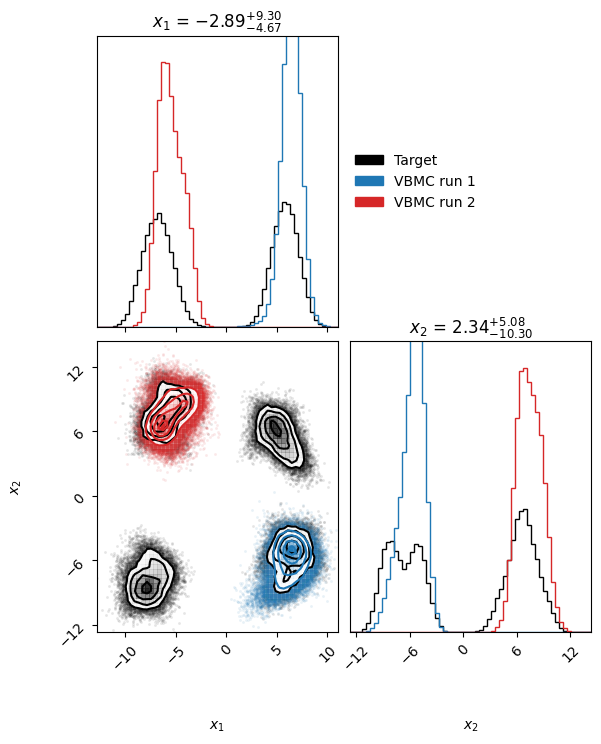

In [7]:
# Sample directly from the target for ground truth
X_gmm_gt = gmm.sample(100000)

# Take samples from VBMC posteriors
vbmc_samples_gmm = []

for m in range(2):
    Xs, _ = vp_list_gmm[m].sample(X_gmm_gt.shape[0]) # same number of samples as the ground truth
    vbmc_samples_gmm.append(Xs)

# Plot
_ = overlay_corner_plot([X_gmm_gt] + vbmc_samples_gmm, 
                        labels = ["Target", "VBMC run 1", "VBMC run 2"], 
                        colors = ["black", "tab:blue", "tab:red"], 
                        base=4, 
                        bins=60)

As in our previous example, VBMC has likely missed a few modes. Let's now fix this with S-VBMC.

**NOTE**: When the evaluations of the log-density of the target are noisy, VBMC is less likely to converge, and the estimates of the individual components of the expected log-joint ($I_k$, see the [S-VBMC paper](https://arxiv.org/abs/2504.05004) for a mathematical definition) are generally noisier. S-VBMC's effectiveness hinges on accurate estimates of these quantities, so setting up filters for excluding bad runs is particularly crucial in these cases. We can adopt the same filters we used in the [basic usage notebook](https://github.com/sfrancesco21/S-VBMC/blob/main/examples/svbmc_example_1_basic_usage.ipynb).

In [ ]:
# Filtering out bad runs, if present
before_filter = len(vp_list_gmm) 
vp_list_gmm = [vp for vp in vp_list_gmm if (vp.stats['stable'] and np.max(vp.stats['J_sjk']) < 5)]
after_filter = len(vp_list_gmm) 
print(f"{before_filter-after_filter} bad runs removed \n\n")

# Initialize `SVBMC` object
vp_stacked_gmm = SVBMC(vp_list=vp_list_gmm)

# Optimize stacked ELBO
vp_stacked_gmm.optimize()


0 bad runs removed 


Optimizing the stacked ELBO w.r.t. all weights
Initial elbo = 2.887497327670369
iter 5: elbo = 2.9878960870099562
iter 10: elbo = 3.0874943788479356
iter 15: elbo = 3.0913528819909297
iter 20: elbo = 3.2335266582163795
iter 25: elbo = 3.219099728208869


Let's visualize the stacked posterior and see how it compares to the ground truth.

**IMPORTANT NOTE**: 

You must use samples from the stacked posterior for any application and should **not** interpret its individual components' sufficient statistics (means and covariance matrices).

This is because each VBMC run may use different internal parameter transformations. Consequently, the component means and covariance matrices from different VBMC posteriors exist in **incompatible parameter spaces**. Combining them creates a mixture whose individual Gaussian components are not directly meaningful.

**Always use samples from the final stacked posterior**, which are correctly transformed back into the original parameter space. These are available via the `.sample()` method:

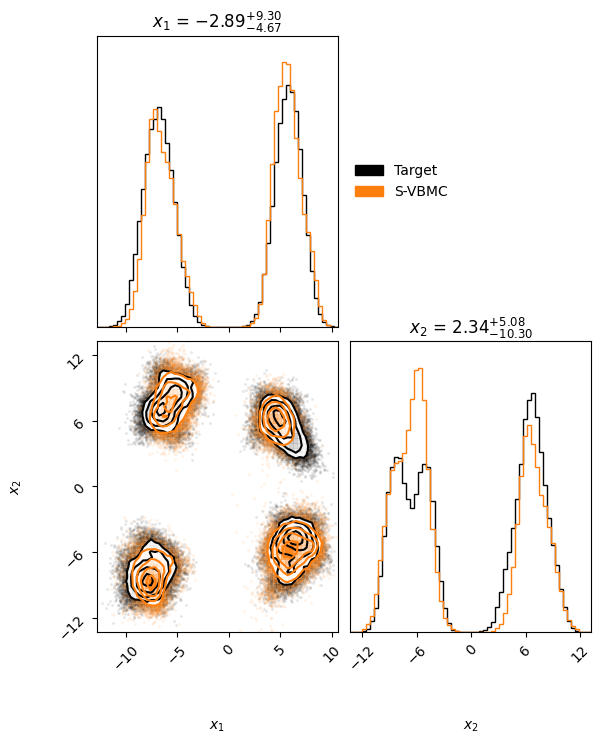

In [9]:
# Take samples from stacked posterior
svbmc_samples_gmm = vp_stacked_gmm.sample(X_gmm_gt.shape[0])

_ = overlay_corner_plot(
        samples = [X_gmm_gt, svbmc_samples_gmm], 
        labels = ["Target", "S-VBMC"], 
        colors = ["black", "tab:orange"], 
        base = 4, 
        bins = 60
        )

Much better!

However, let's check out the S-VBMC estimate of the stacked ELBO. Remember, the ELBO is a lower bound of the log-evidence. In this case our target is an unnormalized mixture of Gaussians, all with a weight of 1. Thus, the log-evidence is $\text{log}(20) \approx 3$. Therefore, the ELBO should be **less than or equal to** (with equality if the posterior perfectly matches the target) this quantity.

In [10]:
print(f'Stacked ELBO: {vp_stacked_gmm.elbo["estimated"]}')

Stacked ELBO: 3.2335266582163795


You'll probably see a value noticeably higher than expected. 

Let's now compute the ELBO via Monte Carlo sampling to get an unbiased estimate of it. Note that **this is not normally possible in scenarios where the density evaluation is expensive**, as the computational costs for accurate estimates would be prohibitive. Therefore, using Monte Carlo estimates as a debiasing method is not feasible in S-VBMC's main use-cases.

In [11]:
# We estimate the expected log-density by evaluating the log-density 
# on all the samples and averaging. We keep the entropy as is.
ELBO_MC = np.mean([gmm.log_pdf(X_gmm_gt[i, :]) for i in range(X_gmm_gt.shape[0])]) + vp_stacked_gmm.entropy 

print(f'Stacked ELBO (unbiased): {ELBO_MC}')

Stacked ELBO (unbiased): 2.90324406612907


This should be lower than 3, which makes more sense. This means that the S-VBMC estimate of the stacked ELBO has a positive bias. We observed this bias in all our experiments with noisy targets, and, crucially, we found that it builds up as more and more posteriors are stacked. Therefore, we incorporated a simple heuristic in our implementation of S-VBMC, which is automatically applied after the stacked ELBO optimization (full discussion and results in the [paper](https://arxiv.org/abs/2504.05004)). 

Let's have a look at our debiased estimate of the stacked ELBO:

In [ ]:
# We recommend using this as the stacked ELBO estimate in problems with noisy likelihoods
print(f'Stacked ELBO (debiased): {vp_stacked_gmm.elbo["debiased_I_median"]}') 

Stacked ELBO (debiased): 2.8975324956256263


This should look much better. Some bias might still be there, as our debiasing method does not completely eliminate it. However, **it keeps it contained** to a negligible amount and **prevents it from building up** with increasing numbers of VBMC posteriors stacked, making the stacked ELBO a more reliable metric for model comparison.